In [118]:
#import libraries
import warnings
warnings.filterwarnings('ignore') 
import pandas as pd
from sodapy import socrata
import geopandas as gpd
import contextily as ctx
import esda 
from esda.moran import Moran, Moran_Local
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_simulation
import libpysal as lps
import matplotlib.pyplot as plt 
import plotly.express as px


In [120]:
#import block grops data
gdf = gpd.read_file('C:/Users/ASUS/Downloads/acs2018_5yr_B01003_15000US060372711003.geojson')


In [122]:
gdf.head()

,geoid,name,B01003001,"B01003001, Error",geometry
0,15000US060371011101,"Block Group 1, Los Angeles, CA",1806.0,332.0,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913..."
1,15000US060371011102,"Block Group 2, Los Angeles, CA",1529.0,375.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
2,15000US060371011103,"Block Group 3, Los Angeles, CA",979.0,250.0,"MULTIPOLYGON (((-118.30080 34.26327, -118.2979..."
3,15000US060371011221,"Block Group 1, Los Angeles, CA",2093.0,410.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
4,15000US060371011222,"Block Group 2, Los Angeles, CA",1146.0,281.0,"MULTIPOLYGON (((-118.29075 34.26906, -118.2906..."


In [124]:
gdf.shape

(2516, 5)

In [126]:
#column selection & renaming
gdf = gdf[['geoid', 'B01003001', 'geometry']]
gdf.columns = ['FIPS', 'TotalPop', 'geometry']

In [128]:
gdf.tail()

,FIPS,TotalPop,geometry
2511,15000US060379800261,37.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
2512,15000US060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
2513,15000US060379800311,1113.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
2514,15000US060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2515,16000US0644000,3959657.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [130]:
gdf['FIPS'] = gdf['FIPS'].str.replace('15000US', '')
gdf.tail()

,FIPS,TotalPop,geometry
2511,060379800261,37.0,"MULTIPOLYGON (((-118.35173 34.28034, -118.3517..."
2512,060379800281,0.0,"MULTIPOLYGON (((-118.45246 33.94315, -118.4464..."
2513,060379800311,1113.0,"MULTIPOLYGON (((-118.29105 33.75378, -118.2905..."
2514,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2515,16000US0644000,3959657.0,"MULTIPOLYGON (((-118.66818 34.18987, -118.6681..."


In [132]:
gdf.sort_values('TotalPop').head()

,FIPS,TotalPop,geometry
2509,060379800231,0.0,"MULTIPOLYGON (((-118.64870 34.23120, -118.6480..."
2506,060379800201,0.0,"MULTIPOLYGON (((-118.34412 34.21700, -118.3438..."
2358,060372772002,0.0,"MULTIPOLYGON (((-118.38597 33.94734, -118.3859..."
2514,060379902000,0.0,"MULTIPOLYGON (((-118.63598 34.03255, -118.6325..."
2508,060379800221,0.0,"MULTIPOLYGON (((-118.50266 34.30809, -118.5026..."


In [134]:
gdf = gdf[gdf['TotalPop']>100]
gdf.head()

,FIPS,TotalPop,geometry
0,060371011101,1806.0,"MULTIPOLYGON (((-118.29133 34.26008, -118.2913..."
1,060371011102,1529.0,"MULTIPOLYGON (((-118.30229 34.25870, -118.3009..."
2,060371011103,979.0,"MULTIPOLYGON (((-118.30080 34.26327, -118.2979..."
3,060371011221,2093.0,"MULTIPOLYGON (((-118.30334 34.27371, -118.3033..."
4,060371011222,1146.0,"MULTIPOLYGON (((-118.29075 34.26906, -118.2906..."


In [136]:
gdf = gdf.to_crs(epsg=3857)

AttributeError: module 'contextily' has no attribute 'add_basemap'

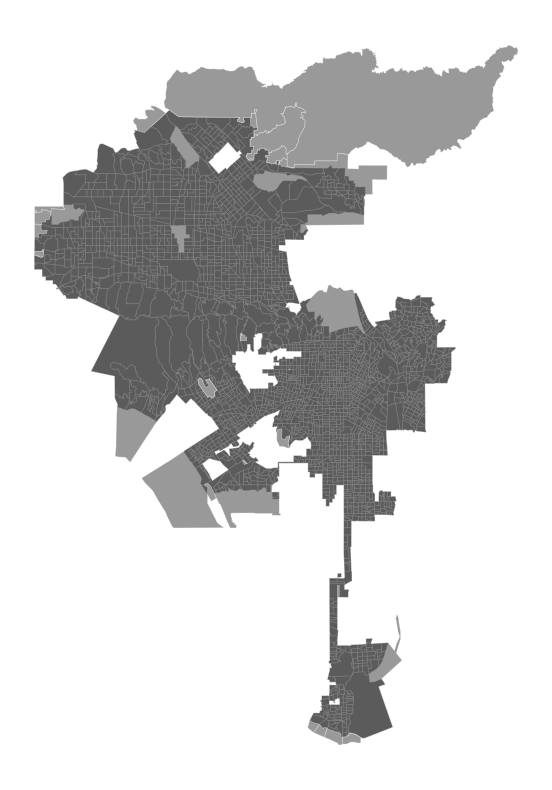

In [138]:
fig, ax = plt.subplots(figsize=(10,10))
gdf.plot(ax=ax,
        color='black',
        edgecolor='white',
        lw=0.5,
        alpha=0.4)
ax.axis('off')
ctx.add_basemap(ax, source=contextily.providers.CartoDB.Position)


In [140]:
arrests = pd.read_csv('C:/Users/ASUS/Downloads/arrests.csv')
arrests.head(3)

,Unnamed: 0,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,...,dispo_desc,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst
0,0,6267132,BOOKING,2021-10-23T00:00:00.000,1000.0,6,Hollywood,669,40,M,...,MISDEMEANOR COMPLAINT FILED,5300 SANTA MONICA BL,34.0929,-118.3048,"{'type': 'Point', 'coordinates': [-118.3048, 3...",2021-10-23T00:00:00.000,1131.0,HOLLYWOOD,4206.0,NaN
1,1,6267204,BOOKING,2021-10-23T00:00:00.000,1350.0,10,West Valley,1039,29,M,...,NaN,VANOWEN,34.1939,-118.4749,"{'type': 'Point', 'coordinates': [-118.4749, 3...",2021-10-23T00:00:00.000,1650.0,VALLEY - JAIL DIV,4279.0,HASKELL
2,2,6267139,BOOKING,2021-10-23T00:00:00.000,1016.0,15,N Hollywood,1503,32,M,...,NaN,HOLLYWOOD FY,34.2003,-118.4002,"{'type': 'Point', 'coordinates': [-118.4002, 3...",2021-10-23T00:00:00.000,1207.0,VALLEY - JAIL DIV,4279.0,SHERMAN WY


In [141]:
arrests = gpd.GeoDataFrame(arrests,
                          crs='EPSG:4326',
                          geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

arrests = arrests.to_crs(epsg=3857)

arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

AttributeError: module 'contextily' has no attribute 'add'

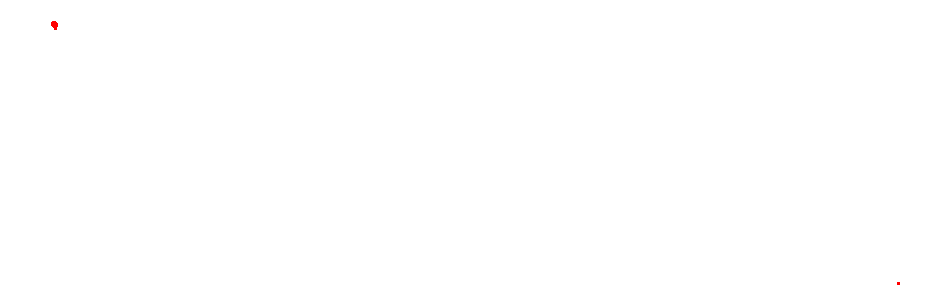

In [144]:
fig,ax = plt.subplots(figsize=(12,12))
arrests.plot(ax=ax,
            color='red',
            markersize=1)
ax.axis('off')
ctx.add.basemap(ax, source=ctx.providers.CartoDB.Position)

In [ ]:
arrests[arrests.lon==0]

In [147]:
arrests= arrests[arrests.lon!=0]

AttributeError: module 'contextily' has no attribute 'add'

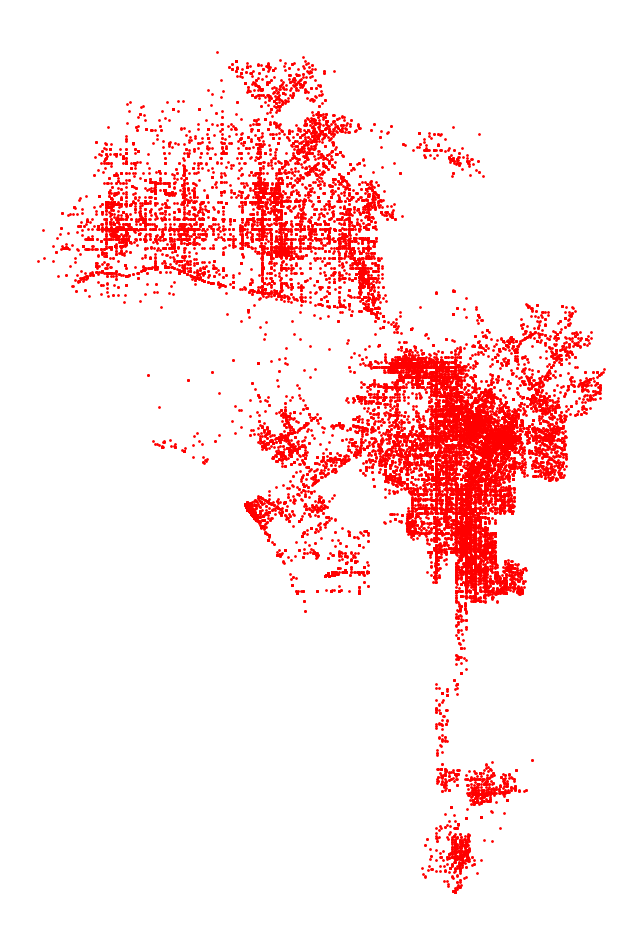

In [149]:
fig,ax = plt.subplots(figsize=(12,12))
arrests.plot(ax=ax,
            color='red',
            markersize=1)
ax.axis('off')
ctx.add.basemap(ax, source=ctx.providers.CartoDB.Position)

AttributeError: module 'contextily' has no attribute 'add'

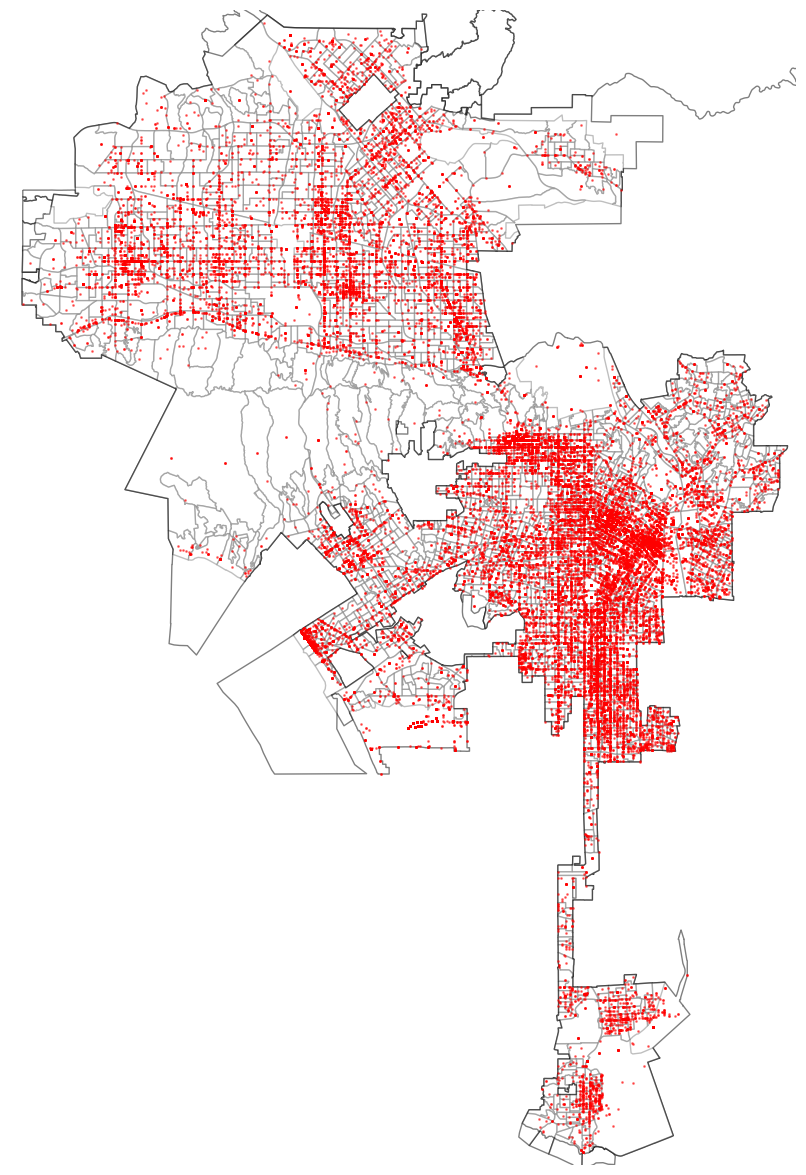

In [151]:
minx, miny, maxx,maxy = arrests.geometry.total_bounds
fig, ax = plt.subplots(1,1, figsize=(15, 15))
# block groups
gdf.plot(ax=ax,
         color='white',
        edgecolor='black',
        alpha=0.5)

# Arrests
arrests.plot(ax=ax,
        color='red',
        markersize=1,
        alpha=0.5)

ax.set_xlim(minx - 1000, maxx + 1000)
ax.set_ylim(miny - 1000, maxy + 1000)

ax.axis('off')

ctx.add.basemap(ax, source=ctx.providers.CartoDB.Position)

In [153]:
# Doing spatial join

join = gpd.sjoin(arrests, gdf, how='left')
join.head()

,Unnamed: 0,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,...,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry,index_right,FIPS,TotalPop
0,0,6267132,BOOKING,2021-10-23T00:00:00.000,1000.0,6,Hollywood,669,40,M,...,"{'type': 'Point', 'coordinates': [-118.3048, 3...",2021-10-23T00:00:00.000,1131.0,HOLLYWOOD,4206.0,NaN,POINT (-13169630.094 4041283.058),2515.0,16000US0644000,3959657.0
0,0,6267132,BOOKING,2021-10-23T00:00:00.000,1000.0,6,Hollywood,669,40,M,...,"{'type': 'Point', 'coordinates': [-118.3048, 3...",2021-10-23T00:00:00.000,1131.0,HOLLYWOOD,4206.0,NaN,POINT (-13169630.094 4041283.058),1036.0,060371911202,1726.0
1,1,6267204,BOOKING,2021-10-23T00:00:00.000,1350.0,10,West Valley,1039,29,M,...,"{'type': 'Point', 'coordinates': [-118.4749, 3...",2021-10-23T00:00:00.000,1650.0,VALLEY - JAIL DIV,4279.0,HASKELL,POINT (-13188565.540 4054867.870),2515.0,16000US0644000,3959657.0
1,1,6267204,BOOKING,2021-10-23T00:00:00.000,1350.0,10,West Valley,1039,29,M,...,"{'type': 'Point', 'coordinates': [-118.4749, 3...",2021-10-23T00:00:00.000,1650.0,VALLEY - JAIL DIV,4279.0,HASKELL,POINT (-13188565.540 4054867.870),536.0,060371276061,1120.0
2,2,6267139,BOOKING,2021-10-23T00:00:00.000,1016.0,15,N Hollywood,1503,32,M,...,"{'type': 'Point', 'coordinates': [-118.4002, 3...",2021-10-23T00:00:00.000,1207.0,VALLEY - JAIL DIV,4279.0,SHERMAN WY,POINT (-13180249.974 4055729.237),2515.0,16000US0644000,3959657.0


In [159]:
arrests_by_gdf = join.FIPS.value_counts().rename_axis('FIPS').reset_index(name='arrests_count')

In [161]:
arrests_by_gdf.head()

,FIPS,arrests_count
0,16000US0644000,36916
1,060371282101,565
2,060372088011,514
3,060372734022,446
4,060372074001,309


<Axes: xlabel='FIPS'>

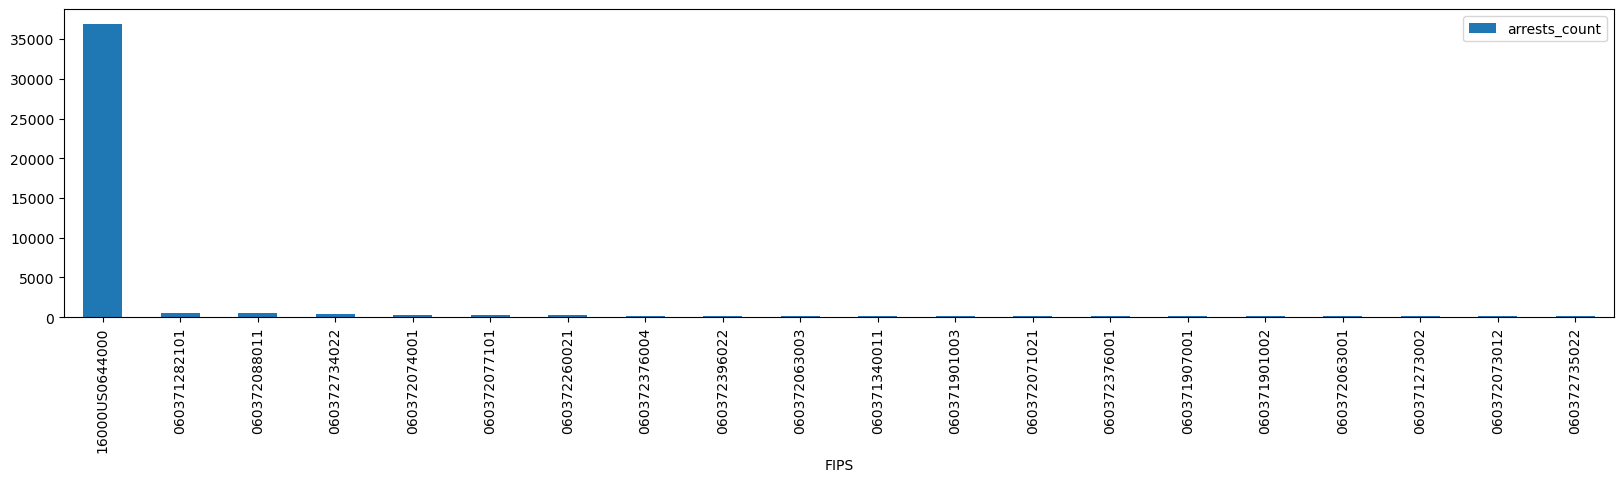

In [163]:
arrests_by_gdf[:20].plot.bar(figsize=(20,4),
                             x='FIPS',
                             y='arrests_count')

In [165]:
# join the summery table
gdf=gdf.merge(arrests_by_gdf,on='FIPS')
gdf.head()

,FIPS,TotalPop,geometry,arrests_count
0,060371011101,1806.0,"MULTIPOLYGON (((-13168130.287 4063777.973, -13...",3
1,060371011102,1529.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",3
2,060371011103,979.0,"MULTIPOLYGON (((-13169185.150 4064208.314, -13...",2
3,060371011221,2093.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",1
4,060371012101,2909.0,"MULTIPOLYGON (((-13168465.581 4062734.852, -13...",8


In [167]:
gdf['arrests_per_1000'] = gdf['arrests_count']/gdf['TotalPop']*1000
gdf['arrests_per_1000'].max()

550.2645502645503

In [172]:
gdf.sort_values(by="arrests_per_1000").tail()

,FIPS,TotalPop,geometry,arrests_count,arrests_per_1000
1218,060372074001,1384.0,"MULTIPOLYGON (((-13163883.226 4036698.552, -13...",309,223.265896
1247,060372088011,1890.0,"MULTIPOLYGON (((-13166927.035 4036610.273, -13...",514,271.957672
2139,060372735022,370.0,"MULTIPOLYGON (((-13189115.569 4026857.882, -13...",125,337.837838
2135,060372734022,960.0,"MULTIPOLYGON (((-13189821.780 4027960.015, -13...",446,464.583333
2341,060379800101,189.0,"MULTIPOLYGON (((-13163713.575 4039600.478, -13...",104,550.264550


In [178]:
wq = lps.weights.KNN.from_dataframe(gdf, k=8)
wq.transform = 'r'

In [182]:
gdf['arrests_per_1000_lag'] = lps.weights.lag_spatial(wq, gdf['arrests_per_1000'])
gdf.head()

,FIPS,TotalPop,geometry,arrests_count,arrests_per_1000,arrests_per_1000_lag
0,060371011101,1806.0,"MULTIPOLYGON (((-13168130.287 4063777.973, -13...",3,1.661130,4.112712
1,060371011102,1529.0,"MULTIPOLYGON (((-13169350.794 4063591.834, -13...",3,1.962067,3.702815
2,060371011103,979.0,"MULTIPOLYGON (((-13169185.150 4064208.314, -13...",2,2.042901,3.932416
3,060371011221,2093.0,"MULTIPOLYGON (((-13169467.902 4065613.937, -13...",1,0.477783,2.710372
4,060371012101,2909.0,"MULTIPOLYGON (((-13168465.581 4062734.852, -13...",8,2.750086,4.297104


In [194]:
gdf.sort_values(by='arrests_lag_diff')

,FIPS,TotalPop,geometry,arrests_count,arrests_per_1000,arrests_per_1000_lag,arrests_lag_diff
1075,060371972002,1423.0,"MULTIPOLYGON (((-13161831.941 4040871.463, -13...",2,1.405481,76.649524,-75.244043
1077,060371973001,1447.0,"MULTIPOLYGON (((-13164056.995 4039670.637, -13...",1,0.691085,72.821184,-72.130099
1196,060372060101,2618.0,"MULTIPOLYGON (((-13162331.543 4037836.577, -13...",29,11.077158,81.355151,-70.277993
2153,060372739022,906.0,"MULTIPOLYGON (((-13188028.423 4026791.427, -13...",5,5.518764,70.756049,-65.237285
1074,060371972001,1371.0,"MULTIPOLYGON (((-13162842.166 4041648.022, -13...",17,12.399708,75.190252,-62.790543
...,...,...,...,...,...,...,...
1218,060372074001,1384.0,"MULTIPOLYGON (((-13163883.226 4036698.552, -13...",309,223.265896,32.629323,190.636573
2139,060372735022,370.0,"MULTIPOLYGON (((-13189115.569 4026857.882, -13...",125,337.837838,99.586988,238.250849
1247,060372088011,1890.0,"MULTIPOLYGON (((-13166927.035 4036610.273, -13...",514,271.957672,26.001226,245.956446
2135,060372734022,960.0,"MULTIPOLYGON (((-13189821.780 4027960.015, -13...",446,464.583333,84.526812,380.056522


In [204]:
y = gdf.arrests_per_1000
moran = Moran(y, wq)
moran.I

0.17726241924540626

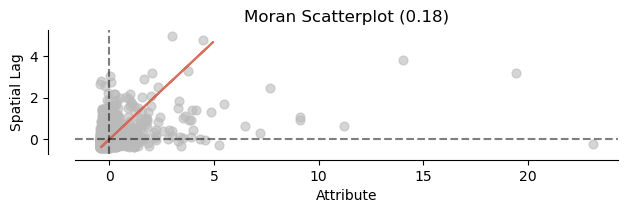

In [206]:
fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

(<Figure size 700x700 with 1 Axes>,
 <Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.18', ylabel='Density'>)

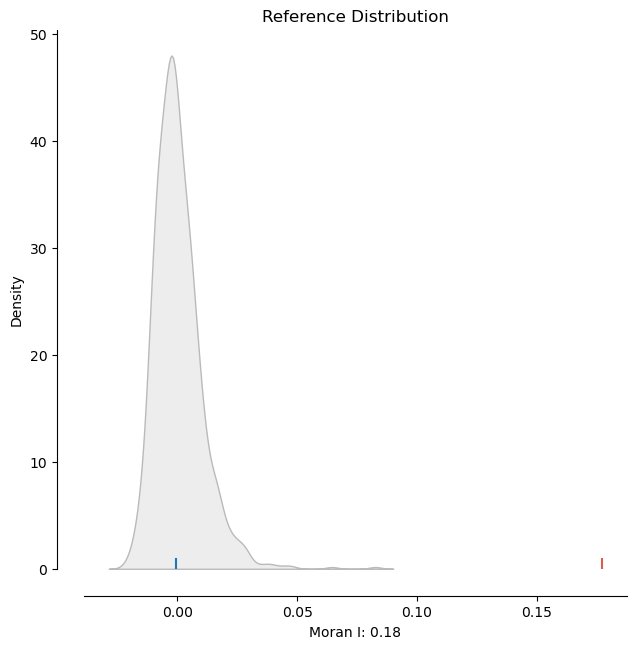

In [210]:
plot_moran_simulation(moran,aspect_equal=False)

In [212]:
moran.p_sim

0.001